# Tutorial: How to predict using a pretrained rnn

## ⚙️ Install grainlearning package 
(Not necessary if you are running jupyter-lab on an environment where grainlearning and rnn dependencies are installed)

pip install grainlearning --extras "rnn"

## 🧪 Explore RNN predictions

In [1]:
import grainlearning.rnn.predict as predict_rnn
from pathlib import Path

### Load the pretrained model

In [2]:
path_to_trained_model = Path('/Users/luisaorozco/Documents/Projects/GrainLearning/grainLearning/grainlearning/rnn/trained_models/rnn_triaxial_undrained')
path_to_data = Path('/Users/luisaorozco/Documents/Projects/GrainLearning/data/TriaxialCompression/triaxial_compression_variable_input.hdf5')

In [3]:
model, train_stats, config = predict_rnn.get_pretrained_model(path_to_trained_model)

2023-03-10 16:48:52.818634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-10 16:48:52.818769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


## 1. Predict from the test dataset
In the preparation of datasets for training, we windowize the time-sequences in *train* and *validation* datasets, but not the *test* dataset.

In [4]:
from grainlearning.rnn.preprocessing import prepare_datasets

We create a copy of `config` that we are going to use for loading the data. Indeed, if in your model you standardize the data (`config["standardize_outputs"] = True`) then when preparing the dataset, the outputs are going to be standardized too. We want the output non-standardized to be able to compare them with the predictions.

In [5]:
config_load_data = config.copy()
config_load_data["raw_data"] = path_to_data
config_load_data["standardize_outputs"] = False

In [6]:
# now we prepare the data
data, _ = prepare_datasets(**config_load_data)

### Calculate predictions 

In [7]:
predictions = predict_rnn.predict_macroscopics(model, data['test'], train_stats, config, batch_size=len(data['test']))
# note that here we are passing `config` instead of `config_load_data`

2023-03-10 16:49:10.419299: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-10 16:49:10.465169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### 📉 Plot the predictions

In [8]:
from grainlearning.rnn.evaluate_model import plot_predictions

2023-03-10 16:49:31.573106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


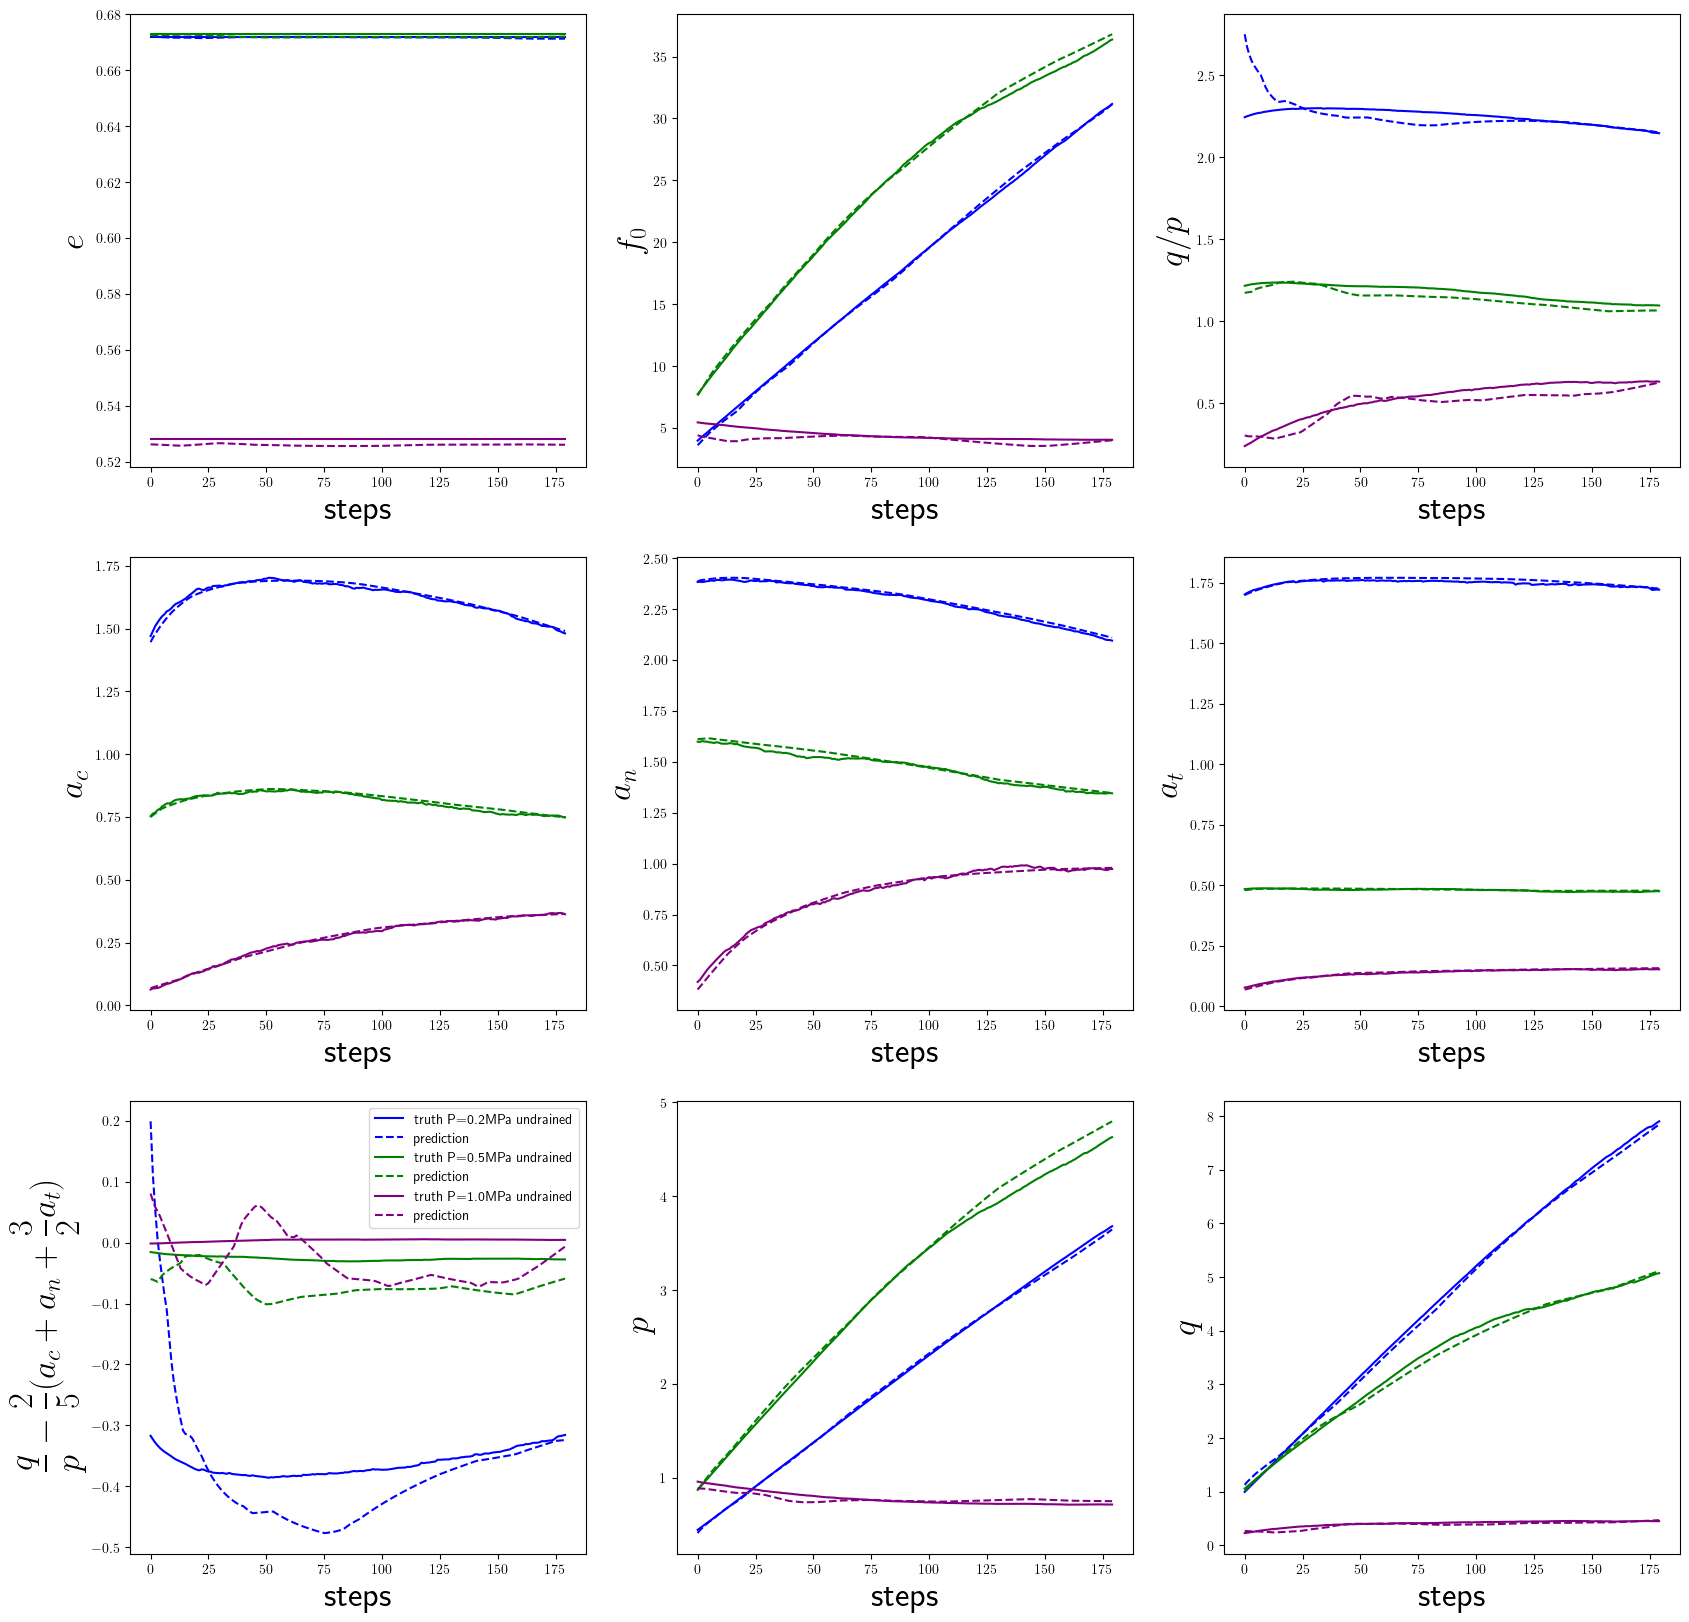

In [9]:
fig = plot_predictions(model, data['test'], train_stats, config, batch_size=len(data['test']))

## 2. Predict from a new dataset not used for training
We use `prepare_single_dataset` that will not windowize the data.

In [10]:
from grainlearning.rnn.preprocessing import prepare_single_dataset

In [11]:
config["raw_data"] = path_to_data
data_2 = prepare_single_dataset(**config)

In [12]:
predictions_2 = predict_rnn.predict_macroscopics(model, data_2, train_stats, config, batch_size=len(data_2))

2023-03-10 16:50:09.630803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### 📉 Plot the predictions

In [13]:
from grainlearning.rnn.evaluate_model import plot_predictions

2023-03-10 16:50:52.273258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


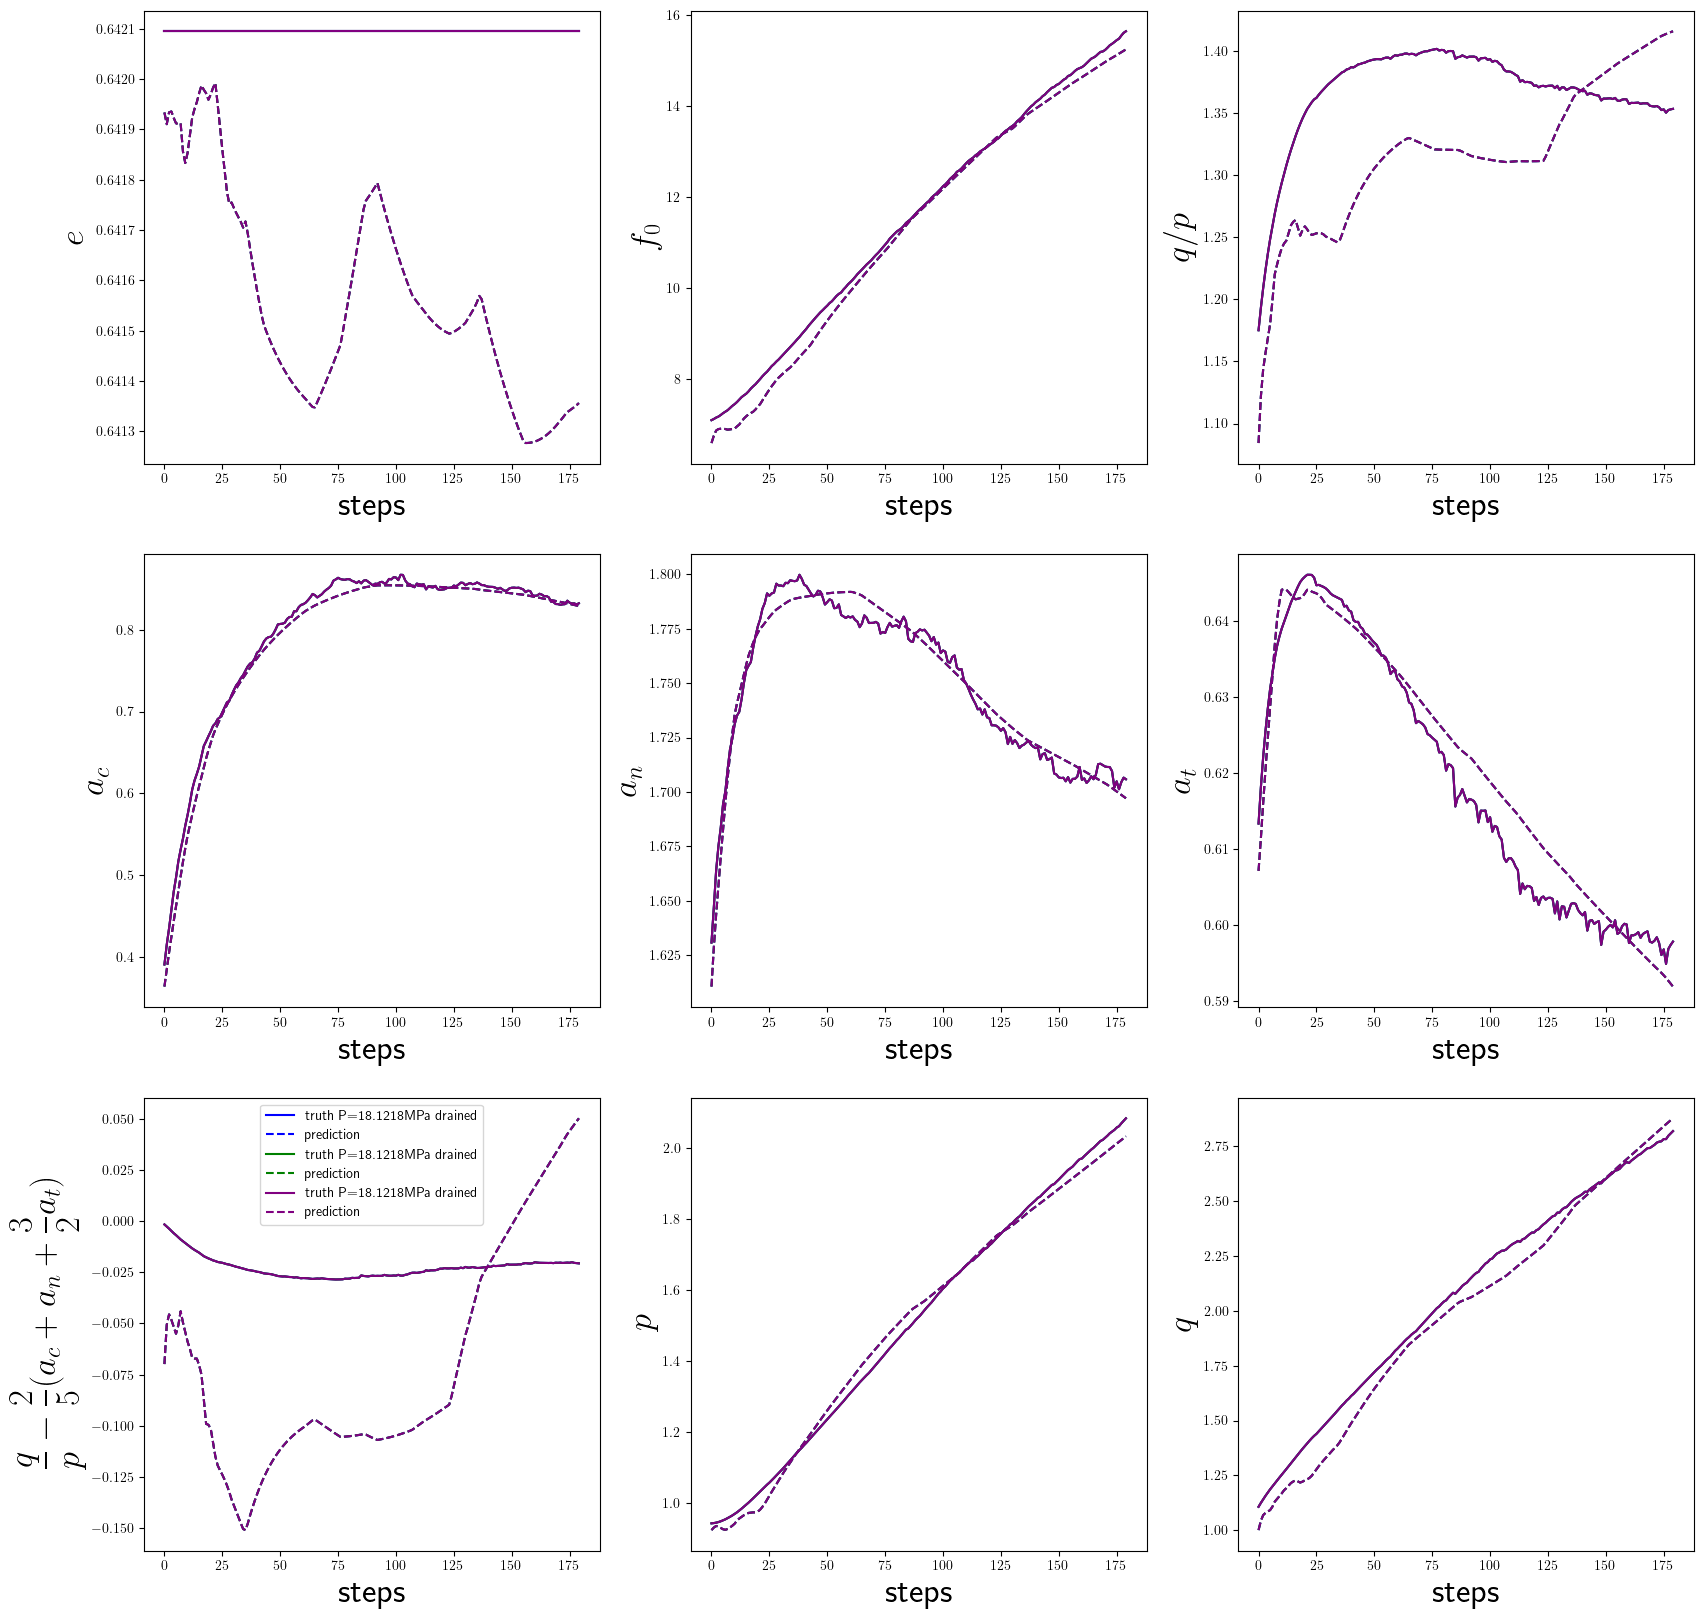

In [14]:
fig_2 = plot_predictions(model, data_2, train_stats, config, batch_size=len(data_2))

## 3. Predict using data in numpy arrays (not in a dataset)
Let's say that we want to use the model to predict from some data that we have in python and don't want to create a separate hdf5 database.

In [15]:
import numpy as np
import tensorflow as tf

We generate two synthetic arrays `contact_params` and `load_sequence` for a single sample for which we want to draw some predictions.

In [16]:
contact_params = np.random.rand( train_stats['num_contact_params'])
load_sequence = np.random.rand(train_stats['sequence_length'], train_stats['num_load_features'])

For compatibility with the RNN we have to add one extra dimension corresponding to the sample.

In [17]:
contact_params = np.expand_dims(contact_params, axis=0)
load_sequence = np.expand_dims(load_sequence, axis=0)

In [18]:
# we draw some predictions using the sliding windows format,
# in agreement with the conditions in which the model was trained.
prediction = [model((load_sequence[:, end - config['window_size']:end], contact_params))
              for end in range(config['window_size'], train_stats['sequence_length'])
             ]
prediction = tf.stack(prediction, axis=1)

#convert the tensor to numpy array
prediction = prediction.numpy()[0]

### 📉 Plot the predictions

In [19]:
from matplotlib import pyplot as plt

In [20]:
steps = np.array(list(range(train_stats['sequence_length'] - config["window_size"])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


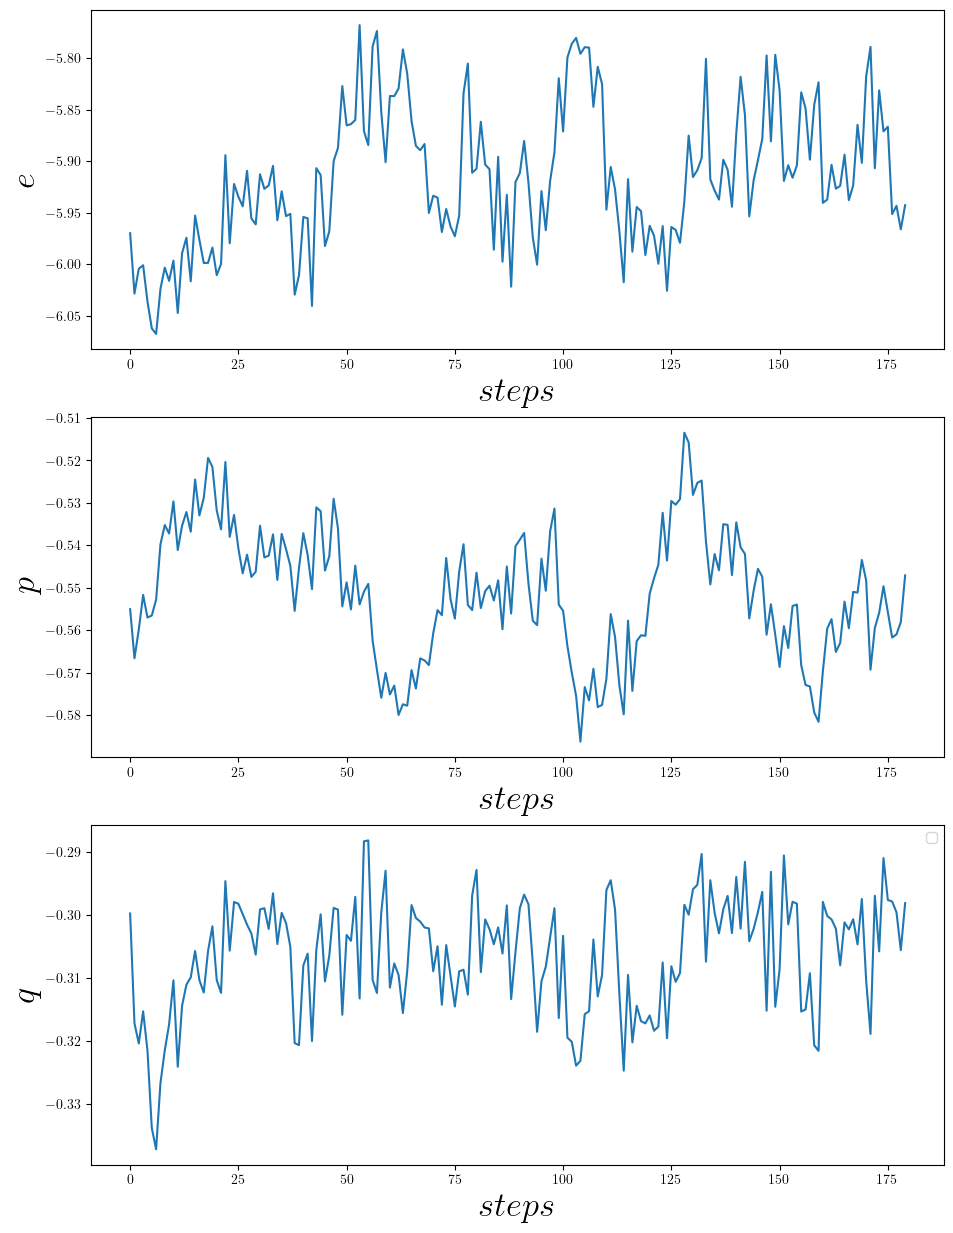

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(11, 15))
ids = {'e': 0, 'p': 1, 'q': 2}
for y_key in ids:
    ax[ids[y_key]].plot(steps, prediction[:,ids[y_key]])
    ax[ids[y_key]].set_xlabel("$steps$")
    ax[ids[y_key]].set_ylabel(rf'${y_key}$')
ax[-1].legend()

In this case the plots don't look like something interesting because we used randomly generated data. 